# Part 02: Fine-tuning Prithvi model using Thailand dataset

## What is Fine-tuning?

According to [IBM](https://www.ibm.com/topics/fine-tuning) *"Fine-tuning in machine learning is the process of adapting a pre-trained model for specific tasks or use cases. It has become a fundamental deep learning technique, particularly in the training process of foundation models used for generative AI."*

For our specific case, the IBM-NASA Prithvi model was trained on the Continental United States data. For it to be usable on different regions (e.g. South East Asia). The model has to be fine-tuned using datasets from the region of interest.

## Preparing the Training Dataset

Before doing the actual finetuning of the Prithvi model, we need to do some additional data preparation first.

In [ ]:
%%time
## Step 1: create the directories for training and test data

import os

# create folder directories for training data
img_train_path = 'output/patch_images_finetuning/img_train'
img_test_path = 'output/patch_images_finetuning/img_test'
lu_train_path = 'output/patch_images_finetuning/lu_train'
lu_test_path ='output/patch_images_finetuning/lu_test'

# this function checks if a folder is already existing and creates that folder it it does not yet exist
def create_folder(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print("{} Folder CREATED successfully.".format(folder_path))
    else:
        print("{} Folder ALREADY EXISTS.".format(folder_path))
        
create_folder(img_train_path)
create_folder(img_test_path)
create_folder(lu_train_path)
create_folder(lu_test_path)

In [ ]:
%%time
## Step 2: Split both the LU and HLS data into training and test

import os
import glob
import shutil

train_split = 0.8 # this means 80% of the patches will be used for model training and the remaining 20% will be used for testing

lu_patches_path = 'output/patch_images/lu' #input the path where you stored the LU patches from the 01_preprocessing notebook
hls_patches_path = 'output/patch_images/hls' #input the path where you stored the HLS patches from the 01_preprocessing notebook

lu_patches_list = glob.glob(os.path.join(lu_patches_path, "*.tif"))
hls_patches_list = glob.glob(os.path.join(hls_patches_path, "*.tif"))

# the train and test paths are the same in the previous cell, and are only added here so this cell can run independently
img_train_path = 'output/patch_images_finetuning/img_train'
img_test_path = 'output/patch_images_finetuning/img_test'
lu_train_path = 'output/patch_images_finetuning/lu_train'
lu_test_path ='output/patch_images_finetuning/lu_test'

# check the total number of patches
print("Total Patches:",len(lu_patches_list))

counter = 1
for lu_patch_path in lu_patches_list:
    #rint(lu_patch_path)
    lu_patch_fname = os.path.basename(lu_patch_path)
    
    # for every 5 patches, we copy the 5th patch to lu_test and img_test
    if counter%5 == 0:
        shutil.copy(lu_patch_path,
                    os.path.join(lu_test_path,lu_patch_fname))
        
        shutil.copy(os.path.join(hls_patches_path,lu_patch_fname),
                    os.path.join(img_test_path,lu_patch_fname))
        
    else:
        shutil.copy(lu_patch_path,
                    os.path.join(lu_train_path,lu_patch_fname))
        
        shutil.copy(os.path.join(hls_patches_path,lu_patch_fname),
                    os.path.join(img_train_path,lu_patch_fname))
    counter += 1

print("HLS Training Patches:",len(glob.glob(os.path.join(img_train_path, "*.tif"))))
print("HLS Test Patches:",len(glob.glob(os.path.join(img_test_path, "*.tif"))))
print("LU Training Patches:",len(glob.glob(os.path.join(lu_train_path, "*.tif"))))
print("LU Test Patches:",len(glob.glob(os.path.join(lu_test_path, "*.tif"))))

## Fine-tuning

#### Before starting

1. When using this Notebook, make sure to use a server with GPU
2. Make sure as well, that you are using an environment with all the Prithvi prerequisites in place (please check jupyter notebook *00_intro_installation_prithvi.ipynb* as reference)
3. The GPU memory required to run the fine-tuning depends on multiple factors, but the main factors are:
    - how fast you want the fine-tuning to be completed?
    - how large is the dataset you are using?

#### Additional Notes

Multiple exploratory experiments were conducted to understand the various aspects and performance of the Prithvi model, the important findings / generalizations from those experiments are listed in this section.

Prithvi is flexible enough to handle multiple classes (5 to 15), however, the quality of the model is highly dependent on two factors:

1. **Balanced Proportion of Classses**
The model performs best if the proportion or % share of the classes are balanced. It doesn't have to be perfectly equal, but it is important that NO ONE CLASS IS OVERWHELMING OTHER CLASSES. An example of an ideal distribution is shown in the table below:
    
| lu class | % share |
|--------------|-------|
| urban | 15 % |
| agricultural | 25 % |
| forest | 20 % |
| water | 10 % |
| oil palm | 15 % |
| para rubber | 15 %|
| TOTAL | 100 % |
        
2. **Quality of the Training Data**
In some cases, the training data itself is not 100% correct. This caused confusion in the model, thus lowering performance in some of the previous experiments.

A key example, is in Bangkok (LU image below). The lower-left section where there is a huge gap in the pixels, is due to that section being classified as Agricultural but with the level 2 classification of Aquaculture. This added confusion to the model and thus was removed from the Land Use map.

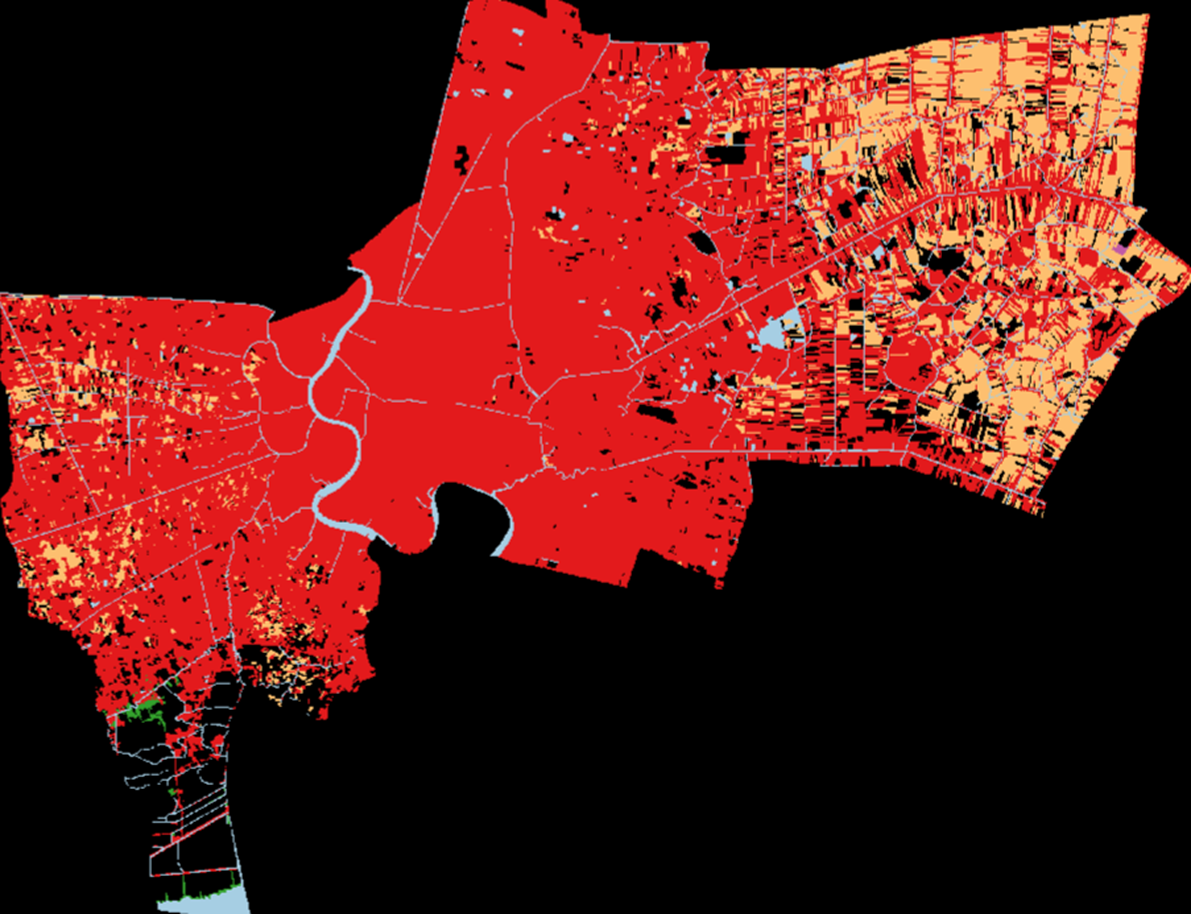

#### MMSeg
In this notebook, we finetune the Prithvi model using the MMSegmentation extension that the IBM-NASA team opensourced.

This is much easier to implement:
- No model surgery required
- No need to write boilerplate training code
- Integrations with Tensorboard, MLFlow, ...
- Segmentation evaluation metrics / losses built in

1. Build your config file, check [MMSeg](https://mmsegmentation.readthedocs.io/en/0.x/tutorials/config.html) for more general tutorials. For this use case, please check `finetuning_config.py` in the scripts folder.
2. Collect your dataset in the format determined by MMSeg
3. Run `mim train mmsegmentation <path to my config>` in the terminal.

#### IMPORTANT:
The cell block below loads the `finetuning_config.py` file. This is just to show how the file looks inside and what parameters are modifiable for the finetuning.

`%load finetuning_config.py` --> use this command to load the config file into a cell

`%%writefile finetuning_config.py` --> use this command to save your edits / overwrite the config file

#### Parameters

The table below shows the parameters that can be modified to adjust the performance of the finetuning.

| Parameter | Description | Experiment Options |
|-----------|------------------------|----------------|
| batch_size | Controls the number of training samples processed together in a single forward and backward pass during model training. | Original value is 8, can be reduced if the finetuning is consuming too much memory (RAM) |
| max_epochs | Total number of training cycles over the dataset. | Impacts how long the finetuning will run |
| eval_epoch_interval | Defines after how many epochs will the model evaluate/test against the test data | |
| num_layers | Controls the depth of the model. | If the model finetuning is overfitting, considering decreasing to 4 |
| patch_size | Controls the size of the patch images, smaller patches give model finer detail but might increase memory consumption. | Consider tests reducing patch_size to 8
| embed_dim | Defines the size of each patch embeddings vector, the higher the value, the richer the representations but also increases model size and memory consumption. | 
| num_heads | Controls the number of attention heads improves the model’s ability to focus on different parts of the input, enhancing representational power. Increasing model heads can help improve to capture spatial relationships. (embed_dim should be divisible by num_heads). | Test increasing to 12 or 16 |
| tubelet_size | Defines how many frames are grouped in the model (useful for video data) |


#### Finetuning config.py

In [ ]:
%%writefile finetuning_config.py

import os, rasterio
img_stack = 'output/HLS_18bands.tif'

dist_params = dict(backend="nccl")
log_level = "INFO"
load_from = None
resume_from = None
cudnn_benchmark = True
custom_imports = dict(imports=["geospatial_fm"])
num_frames = 3
img_size = 224 #size of the patch images used in training (224x224)
num_workers = 1 #original is 4, this is an overall parameter used to define the 

### MODEL PARAMETERS TO BE DEFINED BY USER
pretrained_weights_path = "/prithvi/Prithvi_100M.pt" #"<path to pretrained weights>"

batch_size = 1 # original is 8, but requires much larger memory (RAM)
max_epochs = 50
eval_epoch_interval = 1
num_layers = 1 #
patch_size = 16 #original is 16
embed_dim = 384
num_heads = 4
ftubelet_size = 1

# classes and loss weights can be adjusted by users based on use case
loss_weights_multi = [1.0,
                      1.0,
                      1.0,
                      1.0,
                      2.0,
                      2.0,
                      ]

CLASSES = (
            #"NAN", #blank values
            "URB", #urban
            "AGR", #agricultural
            "FOR", #forest
            "WTR", #water
            "OIL", #oil palm
            "PRB") #para rubber


loss_func = dict(
    type="CrossEntropyLoss",
    use_sigmoid=False,
    class_weight=loss_weights_multi,
    avg_non_ignore=True,
)

#loss_func = dict(
#    type="FocalLoss",
#    gamma=2.0,  # Focuses more on difficult-to-learn classes like PRB
#    alpha=loss_weights_multi,  # Still keeps class weight balancing
#)

output_embed_dim = embed_dim * num_frames

# TO BE DEFINED BY USER: Save directory
experiment = 'exp02' #"<experiment name>"
data_root = 'output/patch_images_finetuning' #<path to data root>
project_dir = 'exp-outputs' #"<project directory name>"
work_dir = os.path.join(project_dir, experiment)
save_path = work_dir

dataset_type = "GeospatialDataset"

## The 18 values for 'means and stds lists' are specific for Thailand, these can be modified if the model is applied to a different region.
img_norm_cfg = dict(    
    means=rasterio.open(img_stack).read().mean(axis=(1,2)).tolist(),
    stds=rasterio.open(img_stack).read().std(axis=(1,2)).tolist(),
)
          
bands = [0, 1, 2, 3, 4, 5]

tile_size = 224
orig_nsize = 512
crop_size = (tile_size, tile_size)
train_pipeline = [
    dict(type="LoadGeospatialImageFromFile", to_float32=True),
    dict(type="LoadGeospatialAnnotations", reduce_zero_label=True),
    dict(type="RandomFlip", prob=0.5),
    dict(type="ToTensor", keys=["img", "gt_semantic_seg"]),
    # to channels first
    dict(type="TorchPermute", keys=["img"], order=(2, 0, 1)),
    dict(type="TorchNormalize", **img_norm_cfg),
    dict(type="TorchRandomCrop", crop_size=crop_size),
    dict(
        type="Reshape",
        keys=["img"],
        new_shape=(len(bands), num_frames, tile_size, tile_size),
    ),
    dict(type="Reshape", keys=["gt_semantic_seg"], new_shape=(1, tile_size, tile_size)),
    dict(type="CastTensor", keys=["gt_semantic_seg"], new_type="torch.LongTensor"),
    dict(type="Collect", keys=["img", "gt_semantic_seg"]),
]

test_pipeline = [
    dict(type="LoadGeospatialImageFromFile", to_float32=True),
    dict(type="ToTensor", keys=["img"]),
    # to channels first
    dict(type="TorchPermute", keys=["img"], order=(2, 0, 1)),
    dict(type="TorchNormalize", **img_norm_cfg),
    dict(
        type="Reshape",
        keys=["img"],
        new_shape=(len(bands), num_frames, -1, -1),
        look_up=dict({"2": 1, "3": 2}),
    ),
    dict(type="CastTensor", keys=["img"], new_type="torch.FloatTensor"),
    dict(
        type="CollectTestList",
        keys=["img"],
        meta_keys=[
            "img_info",
            "seg_fields",
            "img_prefix",
            "seg_prefix",
            "filename",
            "ori_filename",
            "img",
            "img_shape",
            "ori_shape",
            "pad_shape",
            "scale_factor",
            "img_norm_cfg",
        ],
    ),
]


dataset = "GeospatialDataset"
data = dict(
    samples_per_gpu=batch_size, #original is 8, decrease this parameter if the memory consumption is too much
    workers_per_gpu=2, #original is 2
    train=dict(
        type=dataset,
        CLASSES=CLASSES,
        reduce_zero_label=True,
        data_root=data_root,
        img_dir='img_train',
        ann_dir='lu_train',
        pipeline=train_pipeline,
        img_suffix=".tif",
        seg_map_suffix=".tif",
    ),
    val=dict(
        type=dataset,
        CLASSES=CLASSES,
        reduce_zero_label=True,
        data_root=data_root,
        img_dir='img_test',
        ann_dir='lu_test',
        pipeline=test_pipeline,
        img_suffix=".tif",
        seg_map_suffix=".tif",
    ),
    test=dict(
        type=dataset,
        CLASSES=CLASSES,
        reduce_zero_label=True,
        data_root=data_root,
        img_dir='img_test',
        ann_dir='lu_test',
        pipeline=test_pipeline,
        img_suffix=".tif",
        seg_map_suffix=".tif",
    ),
)

optimizer = dict(type="Adam", lr=1e-04, betas=(0.9, 0.999), weight_decay=0.05)
optimizer_config = dict(grad_clip=None)
lr_config = dict(
    policy="poly",
    warmup="linear",
    warmup_iters=1500,
    warmup_ratio=1e-06,
    power=1.0,
    min_lr=0.0,
    by_epoch=False,
)

log_config = dict(
    interval=10, hooks=[dict(type="TextLoggerHook"), dict(type="TensorboardLoggerHook")]
)

checkpoint_config = dict(by_epoch=True, interval=100, out_dir=save_path)

evaluation = dict(
    interval=eval_epoch_interval,
    metric="mIoU",
    pre_eval=True,
    save_best="mIoU",
    by_epoch=True,
)
reduce_train_set = dict(reduce_train_set=False)
reduce_factor = dict(reduce_factor=1)
runner = dict(type="EpochBasedRunner", max_epochs=max_epochs)
workflow = [("train", 1)]
norm_cfg = dict(type="BN", requires_grad=True)

model = dict(
    type="TemporalEncoderDecoder",
    frozen_backbone=False,
    backbone=dict(
        type="TemporalViTEncoder",
        pretrained=pretrained_weights_path,
        img_size=img_size,
        patch_size=patch_size,
        num_frames=num_frames,
        tubelet_size=1,
        in_chans=len(bands),
        embed_dim=embed_dim,
        depth=num_layers,
        num_heads=num_heads,
        mlp_ratio=4.0,
        norm_pix_loss=False,
    ),
    neck=dict(
        type="ConvTransformerTokensToEmbeddingNeck",
        embed_dim=embed_dim * num_frames,
        output_embed_dim=output_embed_dim,
        drop_cls_token=True,
        Hp=14,
        Wp=14,
    ),
    decode_head=dict(
        num_classes=6, #len(CLASSES),
        in_channels=output_embed_dim,
        type="FCNHead",
        in_index=-1,
        channels=256,
        num_convs=1,
        concat_input=False,
        dropout_ratio=0.1,
        norm_cfg=dict(type="BN", requires_grad=True),
        align_corners=False,
        #ignore_index=0, # to remove pixels with 0 values due to LU Gaps
        loss_decode=loss_func,
    ),
    auxiliary_head=dict(
        num_classes=6, #len(CLASSES),
        in_channels=output_embed_dim,
        type="FCNHead",
        in_index=-1,
        channels=256,
        num_convs=2,
        concat_input=False,
        dropout_ratio=0.1,
        norm_cfg=dict(type="BN", requires_grad=True),
        align_corners=False,
        #ignore_index=0, # to remove pixels with 0 values due to LU Gaps
        loss_decode=loss_func,
    ),
    train_cfg=dict(),
    test_cfg=dict(
        mode="slide",
        stride=(int(tile_size / 2), int(tile_size / 2)),
        crop_size=(tile_size, tile_size),
    ),
)

auto_resume = False

In [ ]:
%%time
## this cell runs the finetuning_config.py python file

!mim train mmsegmentation finetuning_config.py

#### IMPORTANT NOTES
For experiment 01, a separate dataset is already prepared.

### Alternative Option

#### Finetuning for your use case
An alternative is to write a PyTorch loop as usual to train on your dataset. Simply extract the backbone from the model with some surgery and run only the model features forward, with no masking.

 In general some reccomendations are:
- At least in the beggining, experiment with freezing the backbone. This will give you much faster iteration through experiments.
- Err on the side of a smaller learning rate
- With an unfrozen encoder, regularization is your friend. (Weight decay, dropout, batchnorm...)